In [1]:
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torch
import numpy as np
import torchvision.transforms as transforms
import argparse
import time
import random
import numpy.ma as ma
import copy
import scipy.misc
import scipy.io as scio
from lib.proj_utils import *
from lib.transformations import translation_matrix, quaternion_matrix, quaternion_from_matrix
import quaternion as qua
from so3_data import *

/hdd/zen/dev/6dof/SO3/lib/transformations.py:1912: UserWarning: failed to import module _transformations
  warnings.warn('failed to import module %s' % name)


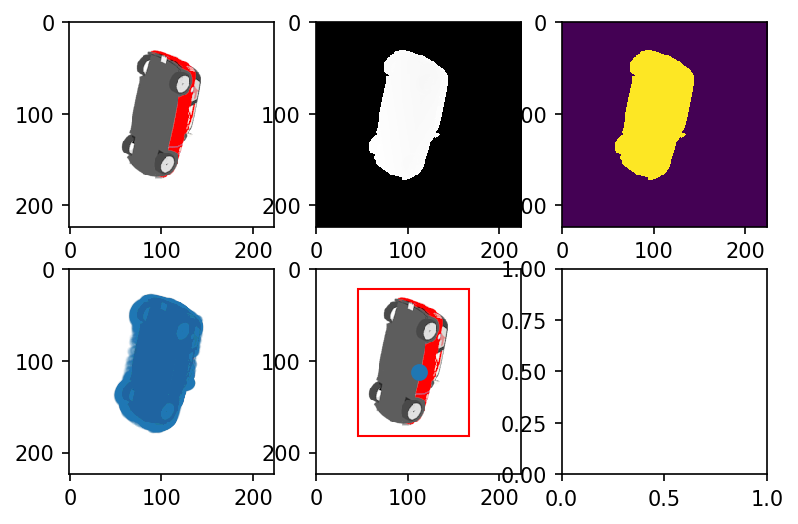

In [5]:
cat = "car"
data_dir = "/hdd/zen/dev/6dof/6dof_data/so3/big"
# data_dir = "/home/qiaog/courses/16720B-project/SO3/data"
model_index = "0000"
index = 10
cld = read_pointxyz( os.path.join(data_dir, cat +"_ycb", "models"))
for index in range(1):
    value, boxes, img_color, depth_img, semantic = diplay_gen_ycb(cat, data_dir, cld, model_index, index)

In [193]:
import matplotlib.pyplot as plt
# dataset_root = "/hdd/zen/dev/6dof/6dof_data/test/car_ycb"
# dataset_root = "/hdd/zen/dev/6dof/6dof_data/so3/small/car_ycb/"
dataset_root = "/hdd/zen/dev/6dof/6dof_data/so3/test/car_ycb/"
# dataset_root = "/home/qiaog/courses/16720B-project/SO3/data/car_ycb"
transform=transforms.Compose([transforms.ToTensor()])
train_dataset = PoseDataset('train', dataset_root, transforms=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=1)

test_dataset = PoseDataset('test', dataset_root, transforms=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)




40
10


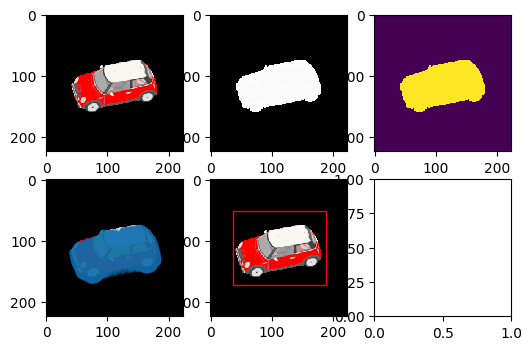

tensor([[2.5652e+03, 0.0000e+00, 1.1200e+02],
        [0.0000e+00, 2.5652e+03, 1.1200e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]]) tensor([-0.0489,  0.1181,  0.3795, -0.9163])


In [195]:
## Data inspection 
for i, d in enumerate(train_loader, 0):
    img, depth, boxes2d, boxes3d, label, pose_r, pose_t, pose, cam,idx= d
    for i in range(2, 4):
#     for i in range(img.shape[0]):
        display_load_img(img[i], depth[i], boxes2d[i][0], label[i], cam[i], pose_t[i], pose_r[i], pose[i], train_dataset.models[idx[i]])
        print(cam[i], pose_r[i])
#         print(np.linalg.det(pose[i][:3,:3]), i)
#         print("------------------------------------------------------------------------------------------")
        break
    break

quat = pose_r[i].numpy()

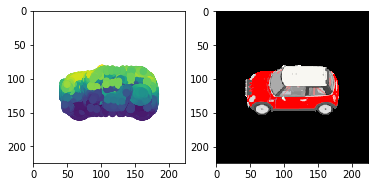

In [197]:
def proj_pts_display(pts, cam, pose, img_org):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.axis('square')
    pts2d = project_to_img(cam, pose, pts)
    ax1.scatter(pts2d[0,:], pts2d[1,:], c = (pts[:,2] * 100).astype(int))
    ax2.imshow(img_org)
    ax1.set_xlim(0, 224)
    ax1.set_ylim(0, 224)
    ax1.invert_yaxis()
    plt.show()
    
## Data inspection 
for i, d in enumerate(train_loader, 0):
    img, depth, boxes2d, boxes3d, label, pose_r, pose_t, pose, cam,idx= d
    for i in range(img.shape[0]):
        img_org = np.transpose(img[i].numpy(), (1,2,0))
        proj_pts_display(cld['0000'], cam[i], pose[i], img_org)
        break
    break


In [115]:
# %matplotlib widget
# %matplotlib inline

In [116]:
blender_cam = np.matrix([[1, 0, 0],
[0, -1, 0],
[0, 0, -1]])

blender_left = np.matrix([[1, 0, 0],
[0, 0, 1],
[0, 1, 0]])

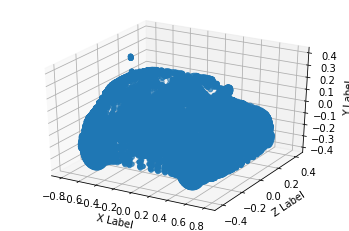

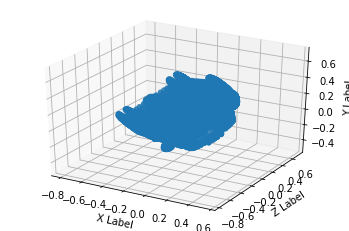

In [137]:
# Data Training loop 
# for i, data in enumerate(train_loader, 0):
#     img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
#     print(pose_r.shape)
#     quat = quaternion_from_matrix(pose_r)
#     break
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.invert_zaxis()
pts = np.copy(cld['0000'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
ax.scatter(point3d[0,:], point3d[2,:], point3d[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')

plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pts = np.copy(cld['0000'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
iden_rot = np.identity(4)[:3,:]

iden_rot[:3, :3] = pose[i][:3,:3]
# ax.invert_zaxis()
point3d_ref = np.matmul(iden_rot, point3d)
ax.scatter(point3d_ref[0,:], point3d_ref[2,:], point3d_ref[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')
plt.show()

In [206]:
def comp_rog(rog1, rog2):
    a1 = np.linalg.norm(rog1)
    a2 = np.linalg.norm(rog2)    
    v1 = rog1/a1
    v2 = rog2/a2
    dist = np.linalg.norm(v1 - v2)
    ang_dist = np.abs(a1 - a2)
    return dist + ang_dist

rog1 = cv2.Rodrigues(pose[0][:3,:3].numpy())[0]
rog2 = cv2.Rodrigues(pose[1][:3,:3].numpy())[0]
comp_rog(rog1, rog2)

0.42429438

In [207]:
def comp_rotation(points, rot1, rot2):
    pt1_proj = rot1.dot(points)
    pt2_proj = rot2.dot(points)
    distance = np.sum(np.linalg.norm(pt1_proj - pt2_proj, axis=0))
    return distance 

points =  np.copy(cld['0001']).T
rot1 = pose[0][:3,:3].numpy()
rot2 = pose[3][:3,:3].numpy()
comp_rotation(points, rot1, rot2)

20194.196052696872

### Not  Fancy Rendering.....

###  Fancy Rendering.....

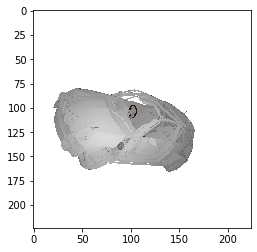

In [134]:
# Render offscreen -- make sure to set the PyOpenGL platform
import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import numpy as np
import trimesh
import pyrender

# Load the FUZE bottle trimesh and put it in a scene
fuze_trimesh = trimesh.load('/hdd/zen/dev/6dof/6dof_data/ShapeNetCore.v1/02958343/1c1a3dc04b6f1f8fd8162cce87567b4/model.obj')
scene = pyrender.Scene.from_trimesh_scene(fuze_trimesh)

nodes = list(scene.nodes)

for i in nodes:
    i.translation = np.array([0,0.0,0])
    i.rotation = quat

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
s = np.sqrt(2)/2

camera_pose = np.array([
       [1.0, 0,   0,   0],
       [0.0,  1.0, 0.0, 0.0],
       [0.0,  0,   1,   1],
       [0.0,  0.0, 0.0, 1.0],
    ])
scene.add(camera, pose=camera_pose)
scene.add(camera)

# Set up the light -- a single spot light in the same spot as the camera
light = pyrender.SpotLight(color=np.ones(3), intensity=5.0,
                               innerConeAngle=np.pi/16.0)
scene.add(light, pose = camera_pose)

# Render the scene
r = pyrender.OffscreenRenderer(224, 224)
color, depth = r.render(scene)

# Show the images
import matplotlib.pyplot as plt
plt.figure()
# plt.subplot(1,2,1)
# plt.axis('off')
plt.imshow(color)
# plt.subplot(1,2,2)
# plt.axis('off')
# plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()
